# Convert classical function to quantum circuit

This is just a toy, but is so cool :)
    
First, we take any classical function as argument to `from_classical()` method:
    
- Function graph is built by running it with range of inputs
- Function graph is converted to statevector (normalized and interpolated to 2**N elements)
- Then we use generator to find circuit which prepares that statevector

Now, when we have circuit, we can produce (near) the same output as classical function with `run()` method:

- executes circuit in many shots and builds histogram of probabilities
- probabilities are converted back to function graph (interpolate and normalize)
- input argument is normalized and correct point from the reconstructed function graph is returned

Here is the code:

In [2]:
from inspect import signature
import numpy as np

from quantastica.qps_api import QPS

from qiskit import QuantumCircuit, execute, Aer
from scipy import interpolate
import matplotlib.pyplot as plt
from IPython.display import SVG

def pd_to_sv(pd, num_qubits):
    len_sv = 2**num_qubits

    # get rid of negative values
    min_val = np.min(pd)
    max_val = np.max(pd)

    if(min_val < 0):
        pd = [i + np.abs(min_val) for i in pd]
    
    # normalize sum to 1
    pd = pd / np.sum(pd)
    
    # Make statevector
    pd = np.sqrt(pd).tolist()
    
    # convert to complex
    sv = [complex(i) for i in pd]

    return sv


def sv_to_pd(sv, pd_min, pd_max):
    pd = np.abs(sv)**2
    
    min_val = np.min(pd)
    max_val = np.max(pd)
    
    pd = [ (pd_max - pd_min) * ((a - min_val) / (max_val - min_val)) + pd_min for a in pd ]
    
    return pd


def get_zero_state(num_qubits):
    zero_state = np.zeros(2**num_qubits, dtype=complex)
    zero_state[0] = 1+0j
    return zero_state


class QuantumFunction:

    def __init__(self):
        self.reset()


    def reset(self):
        self.input_min = 0
        self.input_max = 1
        self.num_qubits = 3
        self.func = None
        self.qasm = ""
        self.use_statevector=True
        self.num_shots = 4096


    def from_classical(self, func, options={}):
        self.reset()

        sig = signature(func)
        if len(list(sig.parameters)) != 1:
            raise Exception("Only classical functions with single argument are supported.")

        self.func = func
            
        if "num_qubits" in options:
            self.num_qubits = options["num_qubits"]

        if "input" in options:
            if "min" in options["input"]:
                self.input_min = options["input"]["min"]
            if "max" in options["input"]:
                self.input_max = options["input"]["max"]

        # Run classical function by providing full input range in 2**num_qubits steps
        # and store outputs in a list (which is a graph of a function)
        inputs = np.linspace(self.input_min, self.input_max, 2**self.num_qubits)        
        outputs = [func(a) for a in inputs]
        self.output_min = np.min(outputs)
        self.output_max = np.max(outputs)

        # Graph of a function is converted to statevector
        output_vector = pd_to_sv(outputs, self.num_qubits)
        
        # Use generator to find circuit which prepares our statevector
        job_id = QPS.generator.state_preparation(output_vector, settings = { "instruction_set": ["u3", "cx"], "max_diff": 0.001, "pre_processing": "experimental5" })
        job = QPS.generator.get_job(job_id, wait=True)
        job_status = job["status"]
        job_output = job["output"]

        if(job_status == "error"):
            raise Exception(job_output["message"])
        else:
            if "circuits" not in job_output or len(job_output["circuits"]) == 0:
                raise Exception("No solutions")

        self.qasm = job_output["circuits"][0]["qasm"]
        
        return self.qasm


    def run(self, x):
        if(x < self.input_min or x > self.input_max):
            raise Exception("Input is out of range [" + str(self.input_min) + ".." + str(self.input_max) + "]")
            
        qc = QuantumCircuit().from_qasm_str(self.qasm)

        if(self.use_statevector):
            # Using statevector (this can run only on simulator)
            backend = Aer.get_backend("statevector_simulator")
            job = execute(qc, backend=backend)
            job_result = job.result()

            output_vector = np.asarray(job_result.get_statevector(qc))
        else:
            # Using counts (this method can be used both with simulator and with QPU)
            qc.measure_all()
            backend = Aer.get_backend("qasm_simulator")
            job = execute(qc, backend=backend, shots=self.num_shots)
            job_result = job.result()
            counts = job_result.get_counts()

            # Reconstruct statevector from counts (we don't use phase, so magnitude is enough)
            output_pd = np.zeros(2**self.num_qubits)
            for key, value in counts.items():
                output_pd[int(key, 2)] = value

            output_vector = pd_to_sv(output_pd, self.num_qubits)
            
        # Reconstruct (normalized) function graph from statevector
        pd = sv_to_pd(output_vector, self.output_min, self.output_max)

        # Interpolate: we have only 2**num_qubits points, but argument is real
        f = interpolate.interp1d(np.linspace(self.input_min, self.input_max, len(output_vector)), pd)
        result = f(x)
        
        return result

    
    def plot(self):
        x = np.linspace(self.input_min, self.input_max, 100)
        
        c = [self.func(a) for a in x]
        q = [self.run(a) for a in x]

        
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(1, 1, 1)

        # plot the functions
        plt.plot(x, c, 'b', label="classical")
        plt.plot(x, q, 'r', label="quantum")

        plt.legend()

        # show the plot
        plt.show()


    def draw(self):
        svg = QPS.converter.convert(self.qasm, "qasm", "svg-inline")
        display(SVG(svg))


    def export(self, dest_format="qasm"):
        
        if(dest_format == "qasm"):
            return self.qasm

        data = QPS.converter.convert(self.qasm, "qasm", dest_format)
        return data



## Example

### Step 1: convert classical function to circuit

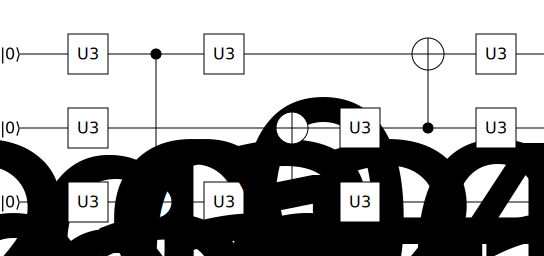

In [3]:
def classical_function(x):
    return x**3

quantum_function = QuantumFunction()

quantum_function.from_classical(classical_function, options={ "input": { "min": -np.pi, "max": np.pi }, "num_qubits": 3 })

quantum_function.draw()



### Step 2: Now we have circuit

Let's plot both original classical and quantum function graph:

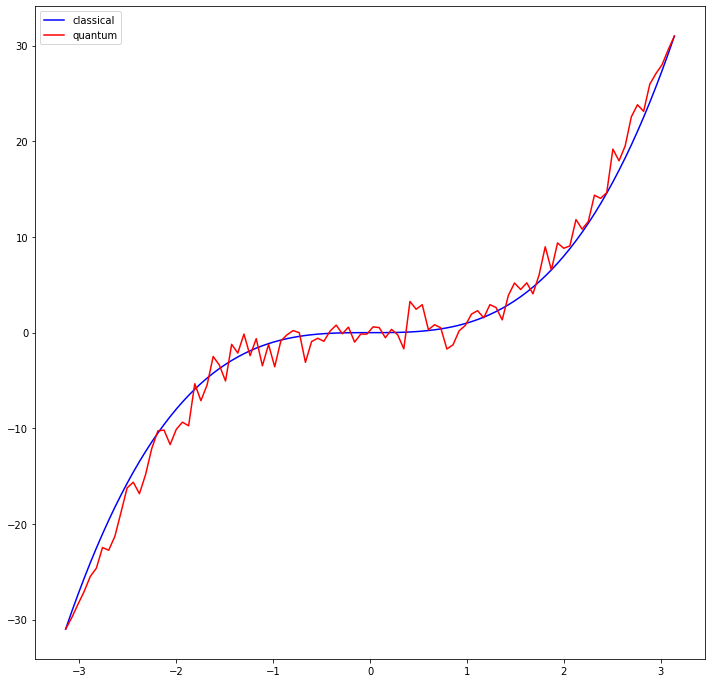

In [4]:

quantum_function.use_statevector = False
quantum_function.plot()


### Step 3: run quantum function and see result

Result is not exact but is close (more qubits and more shots = better accuracy):

In [5]:
y = quantum_function.run(3)

print(y)

27.792513410353617


Voilà!